X size: (612, 64, 64, 3)
Y size: (612, 64, 64)
Training examples:    299
Validation examples:  129
Testing examples:     184
(?, 64, 64, 3)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
E1 (Conv2D)                     (None, 32, 32, 64)   4864        Input[0][0]                      
__________________________________________________________________________________________________
E2 (Conv2D)                     (None, 16, 16, 50)   28850       E1[0][0]                         
__________________________________________________________________________________________________
E3 (Conv2D)                     (None, 8, 8, 32)     14432       E2[

299/299 [==============================] - 14s 47ms/step - loss: 0.0174 - Recon_loss: 0.0108 - Mre_loss: 0.0065
Epoch 38/100
299/299 [==============================] - 15s 49ms/step - loss: 0.0167 - Recon_loss: 0.0101 - Mre_loss: 0.0066
Epoch 39/100
299/299 [==============================] - 14s 47ms/step - loss: 0.0167 - Recon_loss: 0.0102 - Mre_loss: 0.0065
Epoch 40/100
299/299 [==============================] - 14s 48ms/step - loss: 0.0166 - Recon_loss: 0.0102 - Mre_loss: 0.0064
Epoch 41/100
299/299 [==============================] - 15s 50ms/step - loss: 0.0166 - Recon_loss: 0.0101 - Mre_loss: 0.0064
Epoch 42/100
299/299 [==============================] - 14s 47ms/step - loss: 0.0163 - Recon_loss: 0.0099 - Mre_loss: 0.0064
Epoch 43/100
299/299 [==============================] - 14s 48ms/step - loss: 0.0166 - Recon_loss: 0.0100 - Mre_loss: 0.0065
Epoch 44/100
299/299 [==============================] - 15s 50ms/step - loss: 0.0163 - Recon_loss: 0.0099 - Mre_loss: 0.0064
Epoch 45/100


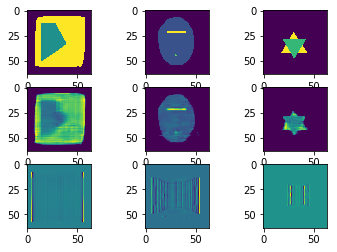

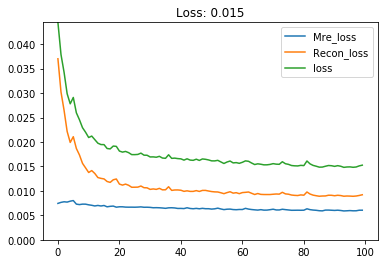

In [3]:

# Basics
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

# Keras
import keras
import keras.backend as K
from keras.models import Model, load_model
from keras.layers import Input, Dense, Conv2D, Lambda, UpSampling2D
from keras.layers import Dot, dot, add

# Others
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

#%matplotlib inline 

df=pd.read_msgpack('MREdata_080618.msg')

def plot_loss(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, historydf.values.max()))
    plt.title('Loss: %.3f' % history.history['loss'][-1])
    
# Prepare Data
Ur = np.stack(df.Ur.values,axis=3).transpose(3,0,1,2)
Ui = np.stack(df.Ui.values,axis=3).transpose(3,0,1,2)
x_data = np.sqrt(Ui**2+Ur**2)

y_data = np.stack(df.RS.values,axis=2).transpose(2,0,1)
y_data = y_data/10000.

print('X size:', x_data.shape)
print('Y size:', y_data.shape)


# Split to Train & Valid
x_train, x_test, y_train, y_test = train_test_split(x_data,y_data,test_size=0.3)
x_train, x_valid, y_train, y_valid = train_test_split(x_train,y_train,test_size=0.3)

print('Training examples:   ', len(x_train))
print('Validation examples: ', len(x_valid))
print('Testing examples:    ', len(x_test))


def laplace(x):
    # Make Kernel
    a = np.asarray([[0., 1., 0.],
                    [1.,-4., 1.],
                    [0., 1., 0.]])    

    a = a.reshape(list(a.shape) + [1,1])
    kernel = K.constant(a,dtype=1)
    
    # Do Convolution
    x = K.expand_dims(K.expand_dims(x, 0), -1)
    y = K.depthwise_conv2d(x,kernel, padding='same')
    
    return y[0,:,:,0]

def laplacian(x):
    u = K.tf.norm(x,axis=3)
    return K.map_fn(laplace,u)


U=np.sqrt(Ur*Ur+Ui*Ui)

# Parameters
xshp   = x_train.shape[1:]
nbatch = 2
nepoch = 100

# Architecture
L1 = 64
L2 = 50
L3 = 32
L4 = 32

# Build Neural Model

# Encoding
x  = Input(shape=xshp,name='Input')
h  = Conv2D(L1,kernel_size=(5,5),strides=(2,2),activation='relu',padding='same',name='E1')(x)
h  = Conv2D(L2,kernel_size=(3,3),strides=(2,2),activation='relu',padding='same',name='E2')(h)
h  = Conv2D(L3,kernel_size=(3,3),strides=(2,2),activation='relu',padding='same',name='E3')(h)
e  = Conv2D(L4,kernel_size=(2,2),strides=(1,1),activation='relu',padding='same',name='E4')(h)

# Decoding
h  = Conv2D(L4,kernel_size=(2,2),activation='relu',padding='same',name='D1')(e)
h  = UpSampling2D((2,2))(h)
h  = Conv2D(L3,kernel_size=(3,3),activation='relu',padding='same',name='D2')(h)
h  = UpSampling2D((2,2))(h)
h  = Conv2D(L2,kernel_size=(3,3),activation='relu',padding='same',name='D3')(h)
h  = UpSampling2D((2,2))(h)
h  = Conv2D(1,kernel_size=(5,5),activation='relu',padding='same',name='D4')(h)
y  = Lambda(lambda xx: K.squeeze(xx,3),name='Recon')(h)

# Laplacian
print(x.shape)

l = Lambda(laplacian,name='Laplacian')(x)

z = dot([y,l],axes=[1,2],name='Mre')
# z = dot([y,l],axes=-1,name='Mre')

# Build Model
#model = Model(inputs=x,outputs=y)
#model.summary()

# Build Aux Model
aux   = Model(inputs=x,outputs=[y,z])
aux.summary()

# Compiling Model
#model.compile(loss='mse',optimizer='adam')
aux.compile(loss='mse',  optimizer='adam')


x_aux = np.linalg.norm(x_train,axis=-1)


# Train Model
log = aux.fit(x_train,[y_train,x_aux],
             epochs=nepoch,
             batch_size=nbatch)


y_pred = aux.predict(x_test)
y_pred1=[y]
# Visualize Examples
nimg=3
for i in range(nimg):
    ax=plt.subplot(3,nimg,i+1)
    plt.imshow(y_test[i+10])
    ax=plt.subplot(3,nimg,i+1+nimg)
    plt.imshow(y_pred[0][i+10])
    ax=plt.subplot(3,nimg,i+1+nimg+nimg)
    plt.imshow(y_pred[1][i+10])   
    
    


plot_loss(log)